_Control

In [ ]:
%reset -f

In [ ]:
# import
import os
import numpy as np
import sympy as sp
import matplotlib as mpl
import pandas as pd
import jax
import jax.numpy as jnp

dspath="./datasets"

In [ ]:
def dummyf(x):
	return x**2

_Notes

AttributeError: module 'numpy' has no attribute 'decoded'

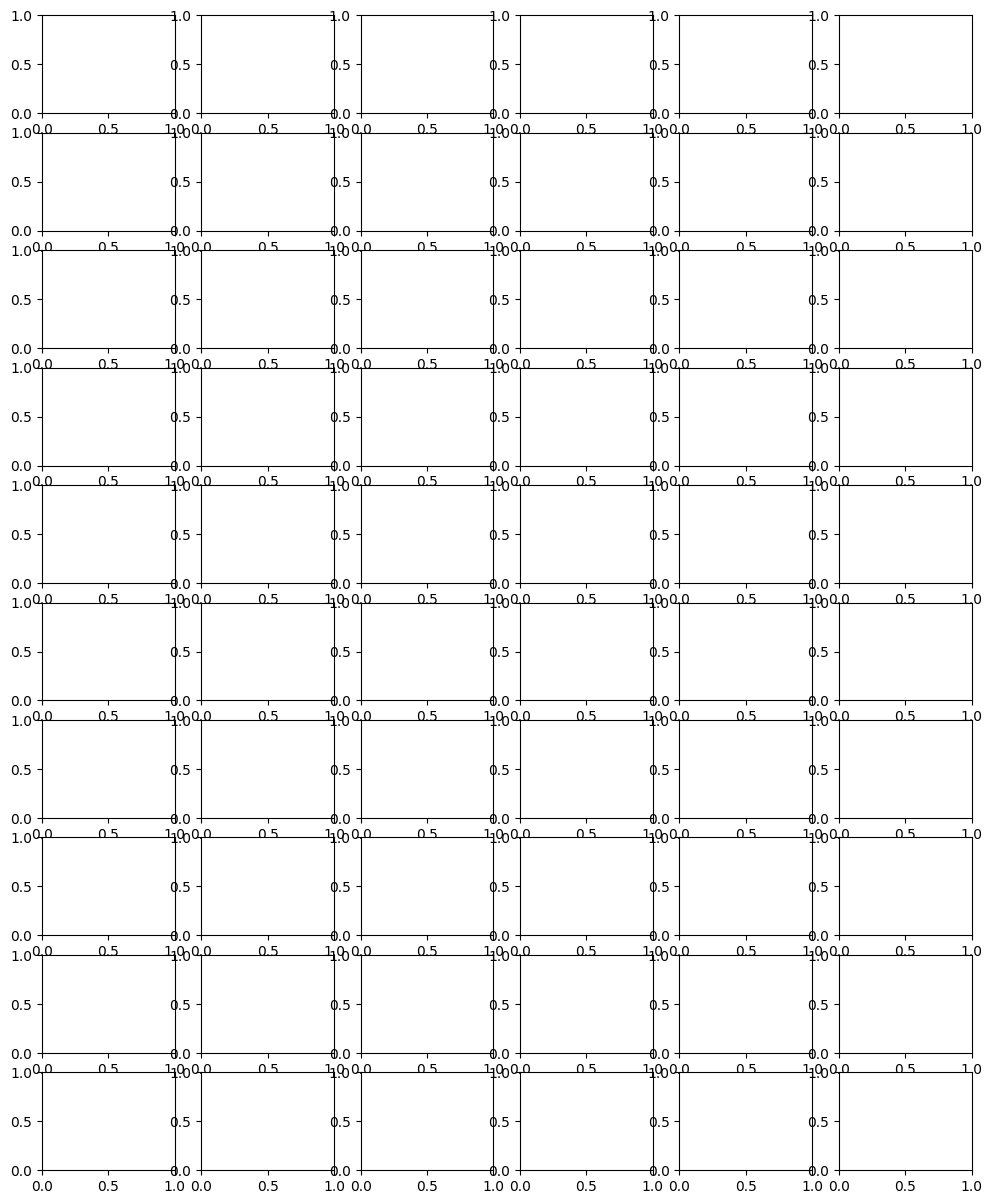

In [ ]:
# matplotlib
import matplotlib.pyplot as plt
import numpy as np

"""
for i in range(decoded.shape[0]):

    array=decoded[i,0,:,:,0]
    
    # Plot the array as a grayscale image
    plt.imshow(array, cmap='gray')

    plt.colorbar()  # Add a color bar to the side for reference
    plt.title('Grayscale Image of 128x128 Array')
    plt.show()
"""

fig, axes = plt.subplots(10, 6, figsize=(12, 15))
for i in range(10):
	for j in range(6):
		array=decoded[6*i+j,0,:,:,0]
		axes[i, j].imshow(array, cmap='gray')
		axes[i, j].set_title(f"Plot {6*i+j+1}")
plt.tight_layout()
plt.show()

In [ ]:
# jax checkpoints
import jax.numpy as jnp
from flax.training import checkpoints
import os
ckpt_dir = os.getcwd()+"/checkpoints/TEST"

restored={}
state = {'a':jnp.ones(16)}
#restored = checkpoints.restore_checkpoint(ckpt_dir, state, prefix=f"_ARRAY_")

checkpoints.save_checkpoint(ckpt_dir, state, 1, prefix=f"_ARRAY_", keep=5, overwrite=True)

In [ ]:
# basic TrainState
import flax.linen as nn
from flax.training.train_state import TrainState
import jax, jax.numpy as jnp
import optax

x = jnp.ones((1,2))
y = jnp.ones((1,2))
z = jnp.array([[1,1],[-2,4],[0,3]])
model = nn.Dense(2)
variables = model.init(jax.random.key(0), x)
tx = optax.adam(2e-2)

state=TrainState.create(apply_fn=model.apply, params=variables, tx=tx)

#print(state.params['params']['kernel'])
#print(model.apply(state.params,z))

def loss(params, x, y):
	predictions=state.apply_fn(params,x)
	return optax.l2_loss(predictions,y).mean()
print(loss(state.params,x,y))

for _ in range(300):
	
	grads=jax.grad(loss)(state.params,x,y)
	state=state.apply_gradients(grads=grads)
	#display(loss(state.params,x,y))

print(state.params)
print(loss(state.params,x,y))

In [ ]:
# transformers pipeline
# long loading time
from transformers import pipeline

'''# Test a pre-trained pipeline (e.g., sentiment-analysis)
classifier = pipeline(task='sentiment-analysis',device='cuda')
print(classifier("Hello World"))
print(classifier(["Hugging Face is amazing!","Red Blue yellow"]))

generator = pipeline("text-generation", model="gpt2", device='cuda')
print(generator("Once upon a time", max_length=50, num_return_sequences=1))
print(generator("I've always been shy growing up.", max_length=250, num_return_sequences=1))'''


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokens1 = tokenizer("Hello, how are you?", return_tensors="pt")
tokens2 = tokenizer("Hello", return_tensors="pt")
print(tokens1)
print(tokens2)

In [ ]:
# PyTorch BatchNorm evaluation mode issue
import torch
import torch.nn as nn
import numpy as np

# Define a BatchNorm layer
bn = nn.BatchNorm1d(3,momentum=0.1)

# Simulate training mode
bn.train()  # Training mode
input_train = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]])
output_train = bn(input_train)
print("Training Mode Output:", output_train)

'''mean_rows = np.mean(np.array(input_train), axis=0)

# Variance along columns (axis=0)
variance_cols = np.var(np.array(input_train), axis=0)

print("Mean along rows:", mean_rows)
print("Variance along columns:", variance_cols)'''


'''print([pn, p] for pn,p in bn.named_parameters())
for pn,p in bn.named_parameters():
	print([pn,p])'''
print(bn.state_dict())

# Switch to evaluation mode
bn.eval()  # Evaluation mode
input_eval = torch.tensor([[4.0, 1.0, 6.0],[7.0, 8.0, 9.0]])
output_eval = bn(input_eval)
print("Evaluation Mode Output:", output_eval)
print(bn.state_dict())

input_eval = torch.tensor([[7.0, 8.0, 9.0]])
output_eval = bn(input_eval)
print("Evaluation Mode Output:", output_eval)
print(bn.state_dict())

In [5]:
# torch .backward, checkpoint
from typing import Iterable
from networkx import non_randomness
from sqlalchemy import false
import torch
import torch.nn as nn
import numpy as np
from torch.utils.checkpoint import checkpoint


x = torch.tensor(4.0, requires_grad=True)
y = x ** 2  # y = x²
y.retain_grad()
z = torch.sin(y)

print(z)
print(y)
print(x)

z.backward()  # Compute gradients
print(x.grad)  # Output: 4.0 (dy/dx = 2*x, at x=2)
print(y.grad)
print(z.grad)

# Define a function to be checkpointed
def forward_func(input):
    return torch.relu(input)
#pdb.set_trace()

# Input tensor
input_tensor = torch.randn(5, requires_grad=True)

# Use checkpoint
output = checkpoint(forward_func, input_tensor, use_reentrant=False)

print(output)

# Backward pass
z=output.sum()
z.backward()
print(input_tensor.grad)

a1=torch.tensor(2.0, requires_grad=True)
a2=torch.tensor(1.0, requires_grad=True)
#a3=torch.tensor([a1+2*a2, a1*a2])
a3=a1+2*a2
a3.backward(gradient=torch.tensor(1))
#a3.backward()
print( [i.grad for i in iter([a1,a2,a3])] )



tensor(-0.2879, grad_fn=<SinBackward0>)
tensor(16., grad_fn=<PowBackward0>)
tensor(4., requires_grad=True)
tensor(-7.6613)
tensor(-0.9577)
None


/tmp/ipykernel_1599/1281635405.py:23: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(z.grad)


tensor([0.0000, 0.0000, 0.0000, 1.5387, 0.0000], grad_fn=<ReluBackward0>)
tensor([0., 0., 0., 1., 0.])
[tensor(1.), tensor(2.), None]


/tmp/ipykernel_1599/1281635405.py:49: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print( [i.grad for i in iter([a1,a2,a3])] )


In [ ]:
# @wrap decorator
from functools import wraps

def my_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print("Wrapper called")
        return func(*args, **kwargs)
    return wrapper

@my_decorator
def my_function():
    """This is my function."""
    pass

print(my_function.__doc__) 
my_function()
#my_decorator(my_function)()

In [ ]:
# ZhipuAI video content description
from zhipuai import ZhipuAI

client = ZhipuAI(api_key='c40bdf30c49ef1d2f40a98b10af2df84.qibzbV4iQBseorFg') # Fill in your own APIKey

'''response = client.chat.completions.create(
    model="glm-4v-plus",  # Fill in the model name to be called
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "video_url",
            "video_url": {
                "url" : "https://videos.pexels.com/video-files/3195394/3195394-sd_426_240_25fps.mp4"
            }
          },
          {
            "type": "text",
            "text": "Please describe this video in detail"
          }
        ]
      }
    ]
)'''

'''response = client.chat.completions.create(
    model="glm-4-plus",  # Fill in the model code you need to call
    messages=[
        {"role": "system", "content": "You are an assistant who loves to answer various questions, your task is to provide users with professional, accurate, and insightful advice."},
        {"role": "user", "content": "A farmer needs to take a wolf, a sheep, and cabbage across a river, but can only take one item at a time, and the wolf and sheep cannot be left alone, nor can the sheep and cabbage. How should the farmer cross the river?"}
    ],
)'''

response = client.chat.completions.create(
    model="glm-4-plus",  # Fill in the model code you need to call
    messages=[
        {"role": "system", "content": ""},
        {"role": "user", "content": "Evaluate the integral ∫x²dx"}
    ],
)
print(response.choices[0].message)

In [ ]:
# all-MiniLM-L6-v2, embedding, 23M params, usage;
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

In [ ]:
# weight must be cloned
n, d, m = 3, 5, 7
embedding = nn.Embedding(n, d, max_norm=1.0)
W = torch.randn((m, d), requires_grad=True)
idx = torch.tensor([1, 2])
a = embedding.weight.clone() @ W.t()  # weight must be cloned for this to be differentiable
b = embedding(idx) @ W.t()  # modifies weight in-place
out = (a.unsqueeze(0) + b.unsqueeze(1))
loss = out.sigmoid().prod()
loss.backward()

In [2]:
# window calculator
import tkinter as tk
from tkinter import messagebox

def calculate_sum():
    try:
        num1 = float(entry1.get())
        num2 = float(entry2.get())
        result = num1 + num2
        messagebox.showinfo("Result", f"The sum is: {result}")
    except ValueError:
        messagebox.showerror("Error", "Please enter valid numbers")

# Create the main window
window = tk.Tk()
window.title("Sum Calculator")

# Create and place the labels and entry widgets
tk.Label(window, text="Enter the first number:").grid(row=0, column=0)
entry1 = tk.Entry(window)
entry1.grid(row=0, column=1)

tk.Label(window, text="Enter the second number:").grid(row=1, column=0)
entry2 = tk.Entry(window)
entry2.grid(row=1, column=1)

# Create and place the calculate button
button = tk.Button(window, text="Calculate", command=calculate_sum)
button.grid(row=2, columnspan=2)

# Start the GUI event loop
window.mainloop()


In [ ]:
# sklearn example
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Load dataset
data = load_iris()
X, y = data.data, data.target # type: ignore

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale features
    ('classifier', RandomForestClassifier(random_state=42))  # Step 2: Classifier
])

# Set hyperparameters for grid search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Predict and evaluate
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [ ]:
# sample flax, optax
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

# Define a simple model using Flax
class MLP(nn.Module):
    features: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Define the loss function
def loss_fn(params, model, batch):
    inputs, targets = batch
    predictions = model.apply({'params': params}, inputs)
    return jnp.mean((predictions - targets) ** 2)

# Training step
@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Initialize model, optimizer, and training state
model = MLP(features=128)
rng = jax.random.PRNGKey(0)
x = jnp.ones((1, 10))  # Example input
params = model.init(rng, x)['params']

optimizer = optax.adam(learning_rate=0.001)
state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer
)

# Example batch
batch = (jnp.ones((32, 10)), jnp.ones((32, 1)))

# Training loop
for _ in range(100):
    state, loss = train_step(state, batch)
    print(f"Loss: {loss}")

In [ ]:
# Apache Spark
"""SimpleApp.py"""
from pyspark.sql import SparkSession

logFile = "/home/mike_1102/miniGPT/minGPT/README.md"  # Should be some file on your system
spark = SparkSession.builder.appName("SimpleApp").getOrCreate()
logData = spark.read.text(logFile).cache()

numAs = logData.filter(logData.value.contains('a')).count()
numBs = logData.filter(logData.value.contains('b')).count()

print("Lines with a: %i, lines with b: %i" % (numAs, numBs))

spark.stop()


Lines with a: 88, lines with b: 50


24/12/01 03:36:10 ERROR ArrowPythonRunner: Python worker exited unexpectedly (crashed)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/mike_1102/miniconda3/envs/env02/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 1225, in main
    eval_type = read_int(infile)
                ^^^^^^^^^^^^^^^^
  File "/home/mike_1102/miniconda3/envs/env02/lib/python3.11/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:572)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:118)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(It

Py4JJavaError: An error occurred while calling o112.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 5.0 failed 1 times, most recent failure: Lost task 0.0 in stage 5.0 (TID 33) (10.255.255.254 executor driver): java.lang.UnsupportedOperationException: sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
	at org.apache.arrow.memory.util.MemoryUtil.directBuffer(MemoryUtil.java:174)
	at org.apache.arrow.memory.ArrowBuf.getDirectBuffer(ArrowBuf.java:229)
	at org.apache.arrow.memory.ArrowBuf.nioBuffer(ArrowBuf.java:224)
	at org.apache.arrow.vector.ipc.WriteChannel.write(WriteChannel.java:133)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.writeBatchBuffers(MessageSerializer.java:303)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.serialize(MessageSerializer.java:276)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeRecordBatch(ArrowWriter.java:147)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeBatch(ArrowWriter.java:133)
	at org.apache.spark.sql.execution.python.BasicPythonArrowInput.writeIteratorToArrowStream(PythonArrowInput.scala:140)
	at org.apache.spark.sql.execution.python.BasicPythonArrowInput.writeIteratorToArrowStream$(PythonArrowInput.scala:124)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner.writeIteratorToArrowStream(ArrowPythonRunner.scala:30)
	at org.apache.spark.sql.execution.python.PythonArrowInput$$anon$1.$anonfun$writeIteratorToStream$1(PythonArrowInput.scala:96)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.execution.python.PythonArrowInput$$anon$1.writeIteratorToStream(PythonArrowInput.scala:102)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:418)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4146)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)
Caused by: java.lang.UnsupportedOperationException: sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
	at org.apache.arrow.memory.util.MemoryUtil.directBuffer(MemoryUtil.java:174)
	at org.apache.arrow.memory.ArrowBuf.getDirectBuffer(ArrowBuf.java:229)
	at org.apache.arrow.memory.ArrowBuf.nioBuffer(ArrowBuf.java:224)
	at org.apache.arrow.vector.ipc.WriteChannel.write(WriteChannel.java:133)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.writeBatchBuffers(MessageSerializer.java:303)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.serialize(MessageSerializer.java:276)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeRecordBatch(ArrowWriter.java:147)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeBatch(ArrowWriter.java:133)
	at org.apache.spark.sql.execution.python.BasicPythonArrowInput.writeIteratorToArrowStream(PythonArrowInput.scala:140)
	at org.apache.spark.sql.execution.python.BasicPythonArrowInput.writeIteratorToArrowStream$(PythonArrowInput.scala:124)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner.writeIteratorToArrowStream(ArrowPythonRunner.scala:30)
	at org.apache.spark.sql.execution.python.PythonArrowInput$$anon$1.$anonfun$writeIteratorToStream$1(PythonArrowInput.scala:96)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.execution.python.PythonArrowInput$$anon$1.writeIteratorToStream(PythonArrowInput.scala:102)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
